In [44]:
import openml
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import warnings
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error, roc_curve, roc_auc_score


In [4]:
dataset = openml.datasets.get_dataset(1590)

In [6]:
X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

In [8]:
df = data = pd.concat([X, y], axis=1)

In [9]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802.0,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40,United-States,<=50K
1,38,Private,89814.0,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50,United-States,<=50K
2,28,Local-gov,336951.0,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40,United-States,>50K
3,44,Private,160323.0,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40,United-States,>50K
4,18,NaN,103497.0,Some-college,10,Never-married,NaN,Own-child,White,Female,0.0,0.0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302.0,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38,United-States,<=50K
48838,40,Private,154374.0,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40,United-States,>50K
48839,58,Private,151910.0,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40,United-States,<=50K
48840,22,Private,201490.0,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20,United-States,<=50K


In [10]:
df = df.dropna()

In [11]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802.0,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40,United-States,<=50K
1,38,Private,89814.0,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50,United-States,<=50K
2,28,Local-gov,336951.0,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40,United-States,>50K
3,44,Private,160323.0,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40,United-States,>50K
5,34,Private,198693.0,10th,6,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302.0,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38,United-States,<=50K
48838,40,Private,154374.0,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40,United-States,>50K
48839,58,Private,151910.0,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40,United-States,<=50K
48840,22,Private,201490.0,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20,United-States,<=50K


In [15]:
X = df.drop(columns=['class'])
y = df['class']

In [30]:
cat_cols = ['workclass','education','marital-status','occupation','relationship','race','native-country']
le = LabelEncoder()
X['sex'] = le.fit_transform(X['sex'])
X = pd.get_dummies(data = X,columns = cat_cols,drop_first=True,prefix_sep='_')

In [31]:
le = LabelEncoder()
y = le.fit_transform(y)

y

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
time_cost = []
memory_cost = []

In [48]:
lgbm_model = lgb.LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42)

start_time = time.time()

lgbm_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

lgbm_accuracy = lgbm_model.score(X_test, y_test)
print("Accuracy:", lgbm_accuracy)

Elapsed Time: 0.29528331756591797
Memory Usage: 151.6171875 MB
Accuracy: 0.8735212824765064


In [49]:
catboost_model = cb.CatBoostClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42,verbose=False)

start_time = time.time()

catboost_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2 
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

catboost_accuracy = catboost_model.score(X_test, y_test)
print("CatBoost Accuracy:", catboost_accuracy)


Elapsed Time: 2.373206853866577
Memory Usage: 151.8984375 MB
CatBoost Accuracy: 0.8718629076838033


In [50]:
xgboost_model = xgb.XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42)

start_time = time.time()

xgboost_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

xgboost_accuracy = xgboost_model.score(X_test, y_test)
print("XGBoost Accuracy:", xgboost_accuracy)

Elapsed Time: 3.5202035903930664
Memory Usage: 163.20703125 MB
XGBoost Accuracy: 0.8740740740740741


In [51]:
print(time_cost)

print(memory_cost)

[0.29528331756591797, 2.373206853866577, 3.5202035903930664]
[151.6171875, 151.8984375, 163.20703125]



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6842
           1       0.79      0.65      0.72      2203

    accuracy                           0.87      9045
   macro avg       0.84      0.80      0.82      9045
weighted avg       0.87      0.87      0.87      9045



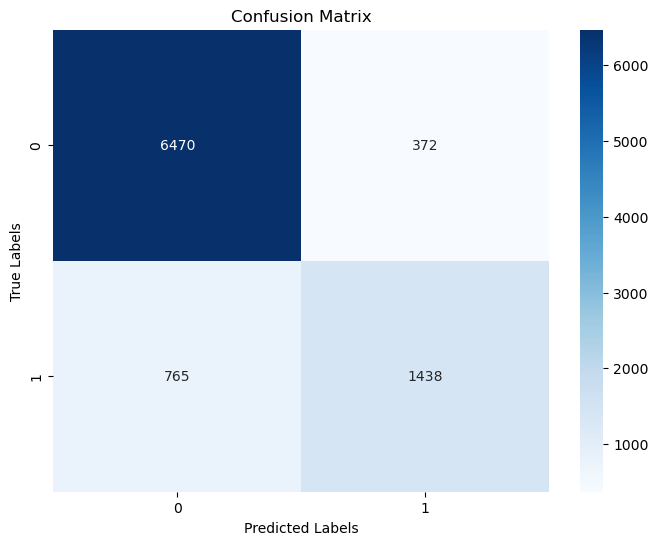

In [37]:
y_pred_lgbm = lgbm_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

class_labels = np.unique(np.concatenate((y_test, y_pred_lgbm)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6842
           1       0.80      0.65      0.72      2203

    accuracy                           0.87      9045
   macro avg       0.84      0.80      0.82      9045
weighted avg       0.87      0.87      0.87      9045



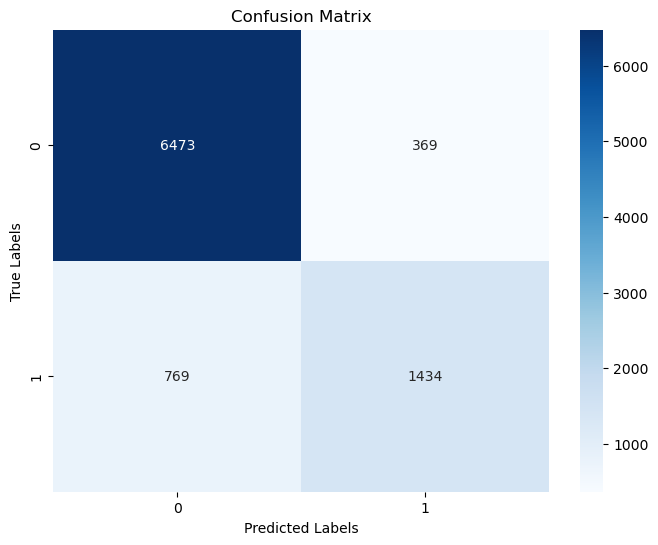

In [38]:
y_pred_cat = catboost_model.predict(X_test)

y_pred_cat = y_pred_cat.flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred_cat))

class_labels = np.unique(np.concatenate((y_test, y_pred_cat)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6842
           1       0.79      0.65      0.72      2203

    accuracy                           0.87      9045
   macro avg       0.84      0.80      0.82      9045
weighted avg       0.87      0.87      0.87      9045



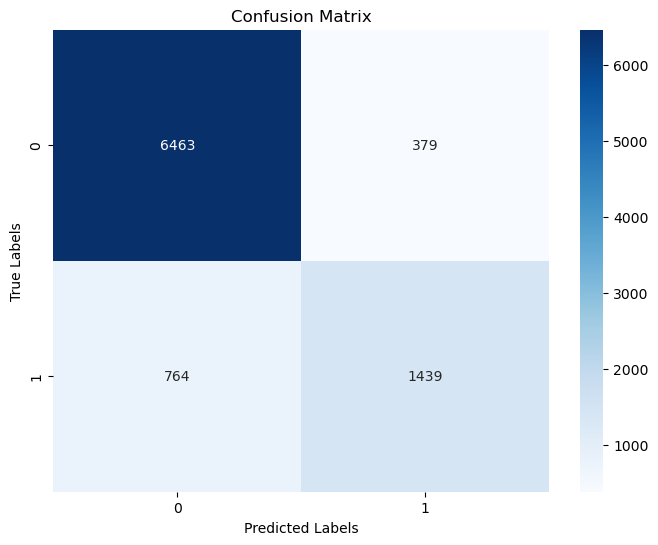

In [39]:
y_pred_xgb = xgboost_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

class_labels = np.unique(np.concatenate((y_test, y_pred_xgb)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

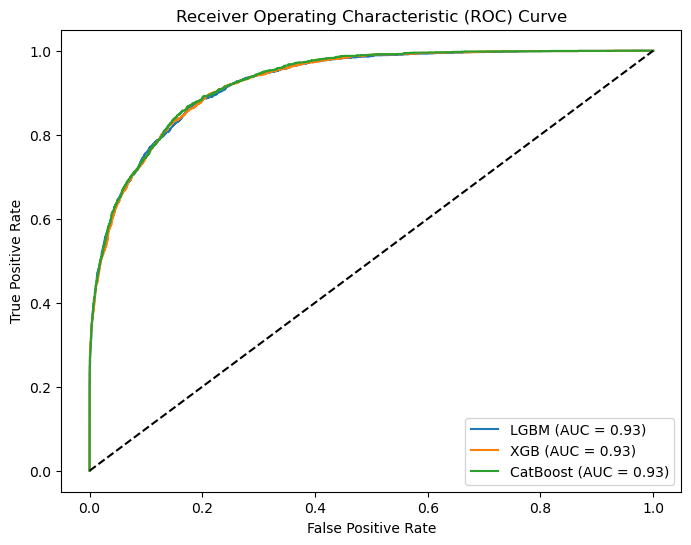

In [40]:
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgboost_model.predict_proba(X_test)[:, 1]
y_pred_proba_cat = catboost_model.predict_proba(X_test)[:, 1]

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_pred_proba_cat)

auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (AUC = {:.2f})'.format(auc_lgbm))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_cat, tpr_cat, label='CatBoost (AUC = {:.2f})'.format(auc_cat))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
logreg = LogisticRegression()

warnings.filterwarnings("ignore")

start_time = time.time()

logreg.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

logreg_accuracy = logreg.score(X_test, y_test)
print("logreg Accuracy:", logreg_accuracy)

Elapsed Time: 0.7109763622283936
Memory Usage: 157.6640625 MB
logreg Accuracy: 0.7954671088999448


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      6842
           1       0.72      0.27      0.39      2203

    accuracy                           0.80      9045
   macro avg       0.76      0.62      0.63      9045
weighted avg       0.78      0.80      0.76      9045



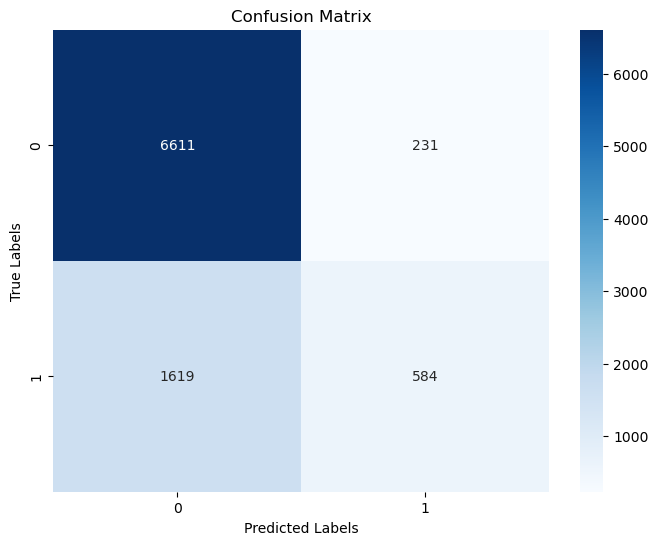

In [46]:
log_pred = logreg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, log_pred))

class_labels = np.unique(np.concatenate((y_test, log_pred)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, log_pred), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()